<a href="https://colab.research.google.com/github/csabiu/ML_tutorial/blob/master/density_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyfftw
!pip install powerbox

     |████████████████████████████████| 2.6 MB 11.2 MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import powerbox as pbox
import time

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Input,BatchNormalization, Dropout, Flatten
from tensorflow.keras.layers import AveragePooling3D, Conv3DTranspose
from tensorflow.keras.layers import concatenate, Concatenate

2.7.0


In [4]:
### USE TPU - check menu Runtime -> change runtime type
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

BaseException: ignored

### Create a 2D lognormal density field

/usr/local/lib/python3.7/dist-packages/powerbox/powerbox.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gpa = np.abs(dft.fft(gca, L=self.boxlength, a=self.fourier_a, b=self.fourier_b))[0]


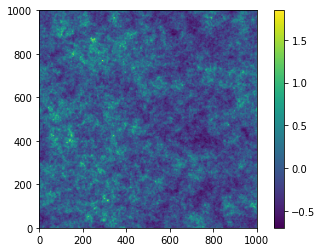

In [5]:
lnpb = pbox.LogNormalPowerBox(
    N=256,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.1*k**-2., # The power-spectrum
    boxlength = 1000.0,           # Size of the box (sets the units of k in pk)
    seed = 1010                # Use the same seed as our powerbox
)
plt.imshow(lnpb.delta_x(),extent=(0,1000,0,1000))
plt.colorbar()
plt.show()

## Create a discrete sampling of the field. 
It looks like it is tracing the above field.

/usr/local/lib/python3.7/dist-packages/powerbox/powerbox.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gpa = np.abs(dft.fft(gca, L=self.boxlength, a=self.fourier_a, b=self.fourier_b))[0]


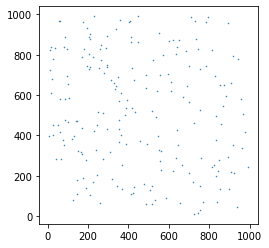

In [6]:
sample=lnpb.create_discrete_sample(nbar=2.0E-4, min_at_zero=True)

#plt.imshow(lnpb.delta_x(),extent=(0,1000,0,1000))
plt.plot(sample[:,0],sample[:,1],'.',markersize=1)
ax=plt.gca()
ax.set_aspect('equal', adjustable='box')

### Create a 3D field, create a discrete Sample, and rebin that sample on a grid

In [17]:
start=time.time()

lnpb = pbox.LogNormalPowerBox(
    N=32,                     # Number of grid-points in the box
    dim=3,                     # 2D box
    pk = lambda k: 0.1*k**-2., # The power-spectrum
    boxlength = 1000.0,           # Size of the box (sets the units of k in pk)
    seed = 1010                # Use the same seed as our powerbox
)

ln_samples = lnpb.create_discrete_sample(nbar=1.0E-4, min_at_zero=True)

grid,edge=np.histogramdd(ln_samples,range=[(0,1000),(0,1000),(0,1000)],bins=32)

print(time.time()-start)

0.0471036434173584


/usr/local/lib/python3.7/dist-packages/powerbox/powerbox.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gpa = np.abs(dft.fft(gca, L=self.boxlength, a=self.fourier_a, b=self.fourier_b))[0]


### create N samples 

In [19]:
inputs=[]
outputs=[]
grid=32

for i in range(500):
  lnpb = pbox.LogNormalPowerBox(N=grid,dim=3,pk = lambda k: 0.1*k**-2.,boxlength = 1000.0,seed = i+1000)
  ln_samples = lnpb.create_discrete_sample(nbar=1.0E-4, min_at_zero=True)
  grid,edge=np.histogramdd(ln_samples,range=[(0,1000),(0,1000),(0,1000)],bins=grid)
  inputs.append(grid)
  outputs.append(lnpb.delta_x())


/usr/local/lib/python3.7/dist-packages/powerbox/powerbox.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gpa = np.abs(dft.fft(gca, L=self.boxlength, a=self.fourier_a, b=self.fourier_b))[0]


### Seperate into trainng and testing sets

In [20]:
split=450
test_data=tf.expand_dims(inputs[split:],-1)/10.0
train_data=tf.expand_dims(inputs[:split],-1)/10.0

test_truth=tf.expand_dims(outputs[split:],-1)
train_truth=tf.expand_dims(outputs[:split],-1)

print(np.shape(train_data))
print(np.shape(train_truth))
print(np.shape(test_data))
print(np.shape(test_truth))

(450, 32, 32, 32, 1)
(450, 32, 32, 32, 1)
(50, 32, 32, 32, 1)
(50, 32, 32, 32, 1)


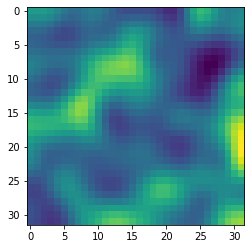

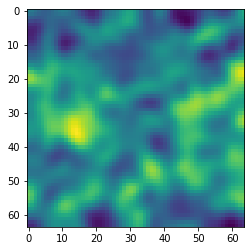

In [15]:
import scipy
#plt.imshow(inputs[0][:,:,1])
plt.imshow(scipy.ndimage.gaussian_filter(inputs[0][:,:,1], 2.))
plt.show()
#plt.imshow(outputs[0][:,:,1])
plt.imshow(scipy.ndimage.gaussian_filter(outputs[0][:,:,1], 2.))
plt.show()

### define tranformers to normalise data (nice 0,1 ranges)

In [21]:
def transform_frw(X,max,min):
  return (X-min)/(max-min)

def transform_back(X,max,min):
  return X*(max-min)+min

max_inputs=np.max(inputs)
min_inputs=np.min(inputs)
max_outputs=np.max(outputs)
min_outputs=np.min(outputs)

### Define U-net architecture

In [22]:
lrelu = 'tanh' #lambda x: tf.keras.activations.elu(x, alpha=0.2)
lrelu_out = lambda x: tf.keras.activations.tanh(x)#,max_value=1.0)
#lrelu='relu'

drop=0.1
def pool(layer):
  #return MaxPooling3D((2, 2, 2))(layer)
  return AveragePooling3D((2, 2,2))(layer)

def build_model(input_layer, start_neurons):
    conv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation=lrelu, padding="same")(input_layer)
    #conv1 = BatchNormalization( )(conv1)
    conv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation=lrelu, padding="same")(conv1)
    #conv1 = BatchNormalization()(conv1)
    pool1 = pool(conv1)
    pool1 = Dropout(drop)(pool1)

    conv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(pool1)
    #conv2 = BatchNormalization()(conv2)
    conv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(conv2)
    #conv2 = BatchNormalization()(conv2)
    pool2 = pool(conv2)
    pool2 = Dropout(drop)(pool2)

    conv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=lrelu, padding="same")(pool2)
    #conv3 = BatchNormalization()(conv3)
    conv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=lrelu, padding="same")(conv3)
    #conv3 = BatchNormalization()(conv3)
    pool3 = pool(conv3)
    pool3 = Dropout(drop)(pool3)

    conv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(pool3)
    #conv4 = BatchNormalization()(conv4)
    conv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(conv4)
    #conv4 = BatchNormalization()(conv4)
    pool4 = pool(conv4)
    pool4 = Dropout(drop)(pool4)

    # Middle
    convm = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(pool4)
    #convm = BatchNormalization()(convm)
    convm = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(convm)
    #convm = BatchNormalization()(convm)

    deconv4 = Conv3DTranspose(start_neurons * 8, (3, 3, 3), strides=(2, 2,2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    #uconv4 = Dropout(drop)(uconv4)
    uconv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(uconv4)
    #uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(uconv4)
    #uconv4 = BatchNormalization()(uconv4)

    deconv3 = Conv3DTranspose(start_neurons * 4, (3, 3, 3), strides=(2, 2,2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    #uconv3 = Dropout(drop)(uconv3)
    uconv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=lrelu, padding="same")(uconv3)
    #uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=lrelu, padding="same")(uconv3)
    #uconv3 = BatchNormalization()(uconv3)

    deconv2 = Conv3DTranspose(start_neurons * 2, (3, 3, 3), strides=(2, 2,2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(drop)(uconv2)
    uconv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(uconv2)
    #uconv2 = BatchNormalization()(uconv2)
    uconv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(uconv2)
    #uconv2 = BatchNormalization()(uconv2)

    deconv1 = Conv3DTranspose(start_neurons * 2, (3, 3, 3), strides=(2, 2,2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(drop)(uconv1)
    uconv1 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(uconv1)
    #uconv1 = BatchNormalization()(uconv1)
    uconv1 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(uconv1)
    #uconv1 = BatchNormalization()(uconv1)
    
    #output_layer = Conv3D(1, (1,1,1), padding="same", activation="sigmoid")(uconv1)
    #output_layer = Conv3D(1, (1,1,1), padding="same", activation=lrelu_out)(uconv1)
    output_layer = Conv3D(1, (1,1,1), padding="same")(uconv1)
    model=Model(inputs=[input_layer],outputs=[output_layer])
    return model

def customLoss(yTrue,yPred):
    import numpy as np
    import tensorflow.keras.backend as K

    #ndim=K.cast(tf.shape(yTrue)[0], dtype='float')

    #yTrueN=yTrue[:,4:60,4:60,4:60,:]
    #yPredN=yPred[:,4:60,4:60,4:60,:]
    
    yTrue=K.cast(yTrue, dtype='float')
    yPred=K.cast(yPred, dtype='float')
    
    yTrue=K.flatten(yTrue)
    yPred=K.flatten(yPred)

    #yTrue=yTrue[yTrue==yTrue]
    #yPred=yPred[yPred==yPred]

    #L=tf.math.reduce_mean((tf.math.log(tf.math.cosh(yTrue - yPred))),axis=-1) #log 
    #L=tf.math.reduce_mean(tf.math.reduce_sum(tf.math.reduce_sum(tf.math.reduce_sum(tf.abs(yTrue-yPred),axis=-1),axis=-1),axis=-1),axis=-1)
    L=tf.math.reduce_sum(tf.pow((yTrue-yPred),2))
    #L=tf.math.reduce_sum(tf.pow((yTrue-yPred),4))

    return L

img_size_target=32

input_layer = Input((img_size_target, img_size_target,img_size_target, 1))
#with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
model_error = build_model(input_layer, 32)

#opt=tf.keras.optimizers.Adam(learning_rate=0.001)
#model_error.compile(optimizer=opt,loss=customLoss)

model_error.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mean_squared_error", metrics=["accuracy"])
model_error.summary(line_length=128)


Model: "model"
________________________________________________________________________________________________________________________________
 Layer (type)                             Output Shape                Param #        Connected to                               
 input_2 (InputLayer)                     [(None, 32, 32, 32, 1)]     0              []                                         
                                                                                                                                
 conv3d (Conv3D)                          (None, 32, 32, 32, 32)      896            ['input_2[0][0]']                          
                                                                                                                                
 conv3d_1 (Conv3D)                        (None, 32, 32, 32, 32)      27680          ['conv3d[0][0]']                           
                                                                                  

### Train the model

In [23]:
#results = model_error.fit(transform_frw(train_data,min_inputs,max_inputs), transform_frw(train_truth,min_outputs,max_outputs), epochs=30, validation_data=(transform_frw(test_data,min_inputs,max_inputs), transform_frw(test_truth,min_outputs,max_outputs)),batch_size=10)#,validation_batch_size=5)
results = model_error.fit(train_data, train_truth, validation_split=0.1, epochs=30,batch_size=20)#,validation_batch_size=5)
#results = model_error.fit(transform_frw(train_data,min_inputs,max_inputs), transform_frw(train_truth,min_outputs,max_outputs), epochs=30, validation_split=0.9,batch_size=35)

Epoch 1/30
21/21 [==============================] - 85s 2s/step - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 2/30
21/21 [==============================] - 43s 2s/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 9.5122e-04 - val_accuracy: 0.0000e+00
Epoch 3/30
21/21 [==============================] - 43s 2s/step - loss: 0.0011 - accuracy: 0.0000e+00 - val_loss: 8.0718e-04 - val_accuracy: 0.0000e+00
Epoch 4/30
21/21 [==============================] - 43s 2s/step - loss: 0.0010 - accuracy: 0.0000e+00 - val_loss: 7.4534e-04 - val_accuracy: 0.0000e+00
Epoch 5/30
21/21 [==============================] - 43s 2s/step - loss: 9.3074e-04 - accuracy: 0.0000e+00 - val_loss: 7.0952e-04 - val_accuracy: 0.0000e+00
Epoch 6/30
21/21 [==============================] - 43s 2s/step - loss: 8.7677e-04 - accuracy: 0.0000e+00 - val_loss: 6.8608e-04 - val_accuracy: 0.0000e+00
Epoch 7/30
21/21 [==============================] - 43s 2s/step - loss: 8.3730e-04 -

KeyboardInterrupt: ignored

### Plot the learning rate

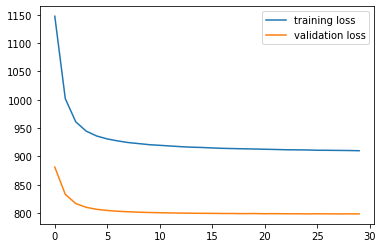

In [ ]:
plt.plot(results.history['loss'],label='training loss')
plt.plot(results.history['val_loss'],label='validation loss')
plt.legend()

### Make a prediction from trained model
remembering to transform the data forward and then backwards (normalisation)

In [ ]:
#preds = transform_back(model_error.predict(transform_frw(test_data,min_inputs,max_inputs), verbose=1),min_outputs,max_outputs)
preds = model_error.predict(test_data, verbose=1)

2/2 [==============================] - 2s 1s/step


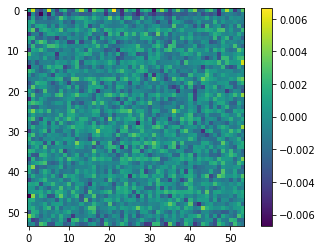

In [ ]:
plt.imshow(preds[1,10,5:-5,5:-5,0])
plt.colorbar()

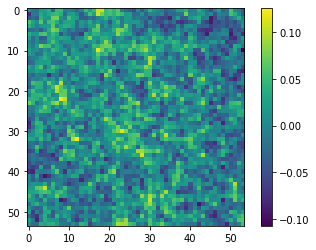

In [ ]:
plt.imshow(test_truth[1,10,5:-5,5:-5,0])
plt.colorbar()

In [24]:
lrelu = lambda x: tf.keras.activations.elu(x, alpha=0.2)
lrelu_out = lambda x: tf.keras.activations.tanh(x)#,max_value=1.0)
#lrelu='relu'

drop=0.1
def pool(layer):
  #return MaxPooling3D((2, 2, 2))(layer)
  return AveragePooling3D((2, 2,2))(layer)

def build_model(input_layer, start_neurons):
    conv1 = Conv3D(start_neurons * 3, (5, 5, 5), activation=lrelu, padding="same")(input_layer)
    #conv1 = BatchNormalization()(conv1)
    conv1 = Conv3D(start_neurons * 3, (5, 5, 5), activation=lrelu, padding="same")(conv1)
    conv1 = Dropout(drop)(conv1)
    conv1 = Conv3D(start_neurons * 3, (5, 5, 5), activation=lrelu, padding="same")(conv1)
    #conv1 = Dropout(drop)(conv1)
    #conv1 = Conv3D(start_neurons * 4, (3, 3, 3), activation=lrelu, padding="same")(conv1)
    #conv1 = Dropout(drop)(conv1)
    #conv1 = Conv3D(start_neurons * 4, (3, 3, 3), activation=lrelu, padding="same")(conv1)

    #output_layer = Conv3D(1, (1,1,1), padding="same", activation="sigmoid")(conv1)
    #output_layer = Conv3D(1, (1,1,1), padding="same", activation=lrelu_out)(conv1)
    output_layer = Conv3D(1, (1,1,1), padding="same")(conv1)
    model=Model(inputs=[input_layer],outputs=[output_layer])
    return model

def customLoss(yTrue,yPred):
    import numpy as np
    import tensorflow.keras.backend as K

    #yTrueN=yTrue[:,4:60,4:60,4:60,:]
    #yPredN=yPred[:,4:60,4:60,4:60,:]

    yTrueN=yTrue[:,2:30,2:30,2:30,:]
    yPredN=yPred[:,2:30,2:30,2:30,:]
    
    yTrue=K.cast(yTrue, dtype='float')
    yPred=K.cast(yPred, dtype='float')
    
    yTrue=K.flatten(yTrue)
    yPred=K.flatten(yPred)


    #L=tf.math.reduce_sum((tf.math.log(tf.math.cosh(yTrue - yPred)))) #log 
    #L=tf.math.reduce_sum(tf.abs(yTrue-yPred))
    #L=tf.math.reduce_sum(tf.pow((yTrue-yPred),2))
    L=tf.math.reduce_sum(tf.pow((yTrue-yPred),4))

    return L

img_size_target=32

input_layer = Input((img_size_target, img_size_target,img_size_target, 1))
#with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
model_error = build_model(input_layer, 32)

opt=tf.keras.optimizers.Adam(learning_rate=0.0001)
model_error.compile(optimizer=opt,loss=customLoss)

#model_error.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss="mean_squared_error", metrics=["accuracy"])
model_error.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 32, 1)]   0         
                                                                 
 conv3d_19 (Conv3D)          (None, 32, 32, 32, 96)    12096     
                                                                 
 conv3d_20 (Conv3D)          (None, 32, 32, 32, 96)    1152096   
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 32, 96)    0         
                                                                 
 conv3d_21 (Conv3D)          (None, 32, 32, 32, 96)    1152096   
                                                                 
 conv3d_22 (Conv3D)          (None, 32, 32, 32, 1)     97        
                                                                 
Total params: 2,316,385
Trainable params: 2,316,385
Non-tra

In [28]:
results = model_error.fit(train_data, train_truth, validation_split=0.1, epochs=30,batch_size=20)#,validation_batch_size=5)


Epoch 1/30
 1/21 [>.............................] - ETA: 1:39 - loss: 0.7415

KeyboardInterrupt: ignored

2/2 [==============================] - 10s 4s/step


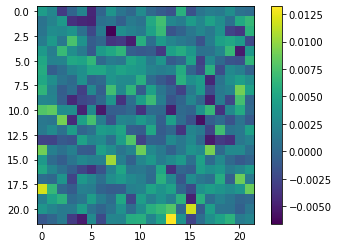

In [26]:
preds = model_error.predict(test_data, verbose=1)
plt.imshow(preds[1,10,5:-5,5:-5,0])
plt.colorbar()

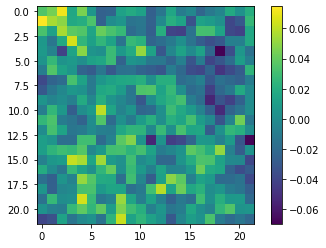

In [27]:
plt.imshow(test_truth[1,10,5:-5,5:-5,0])
plt.colorbar()